# Predição do valor das transações de clientes potenciais do banco Santander

Este é um projeto obtido pelo site do Kaggle de uma competição, para mais informações entre no site do kaggle pelo link abaixo do dataset. Neste projeto podemos observar como a escolha de uma métrica de comparaçaõ de resíduos adequada pode ser muito importante.

Ajude **Santander** a identificar o valor das transações para cada cliente potencial. Esse é um primeiro passo que o **Santander** precisa acertar para personalizar seus serviços em grande escala.

Baixa o dataset *train* no url seguinte, pois é o único que está com os labels:  
https://www.kaggle.com/c/santander-value-prediction-challenge/data

O case podera ser quebrado nas **6** partes seguintes:  
- **Identificar o problema**
  - Qual o tipo (classificaçao, regressao, clustering) de problema e porque? 
- **Necessidades de aplicar transformaçoes?**
  - Ex: *imputing* de valores null, *encoding* de colunas *string*, etc 
- **Separar os sets de treinamento e teste**
- **Baseline**
  - Achar uma baseline, um primeiro modelo para ter uma referencia
- **Escolher a metrica**
- **Melhorar o resultado**
  - Feature engineering, otimizaçao do modelo, hiperparametros, etc

In [30]:
# carregando os dados 

import pandas as pd

import warnings
warnings.simplefilter("ignore")

df = pd.read_csv("train.csv")
df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [31]:
# dimensão do dataset
df.shape

(4459, 4993)

In [32]:
# contagem de valores nulos 
df.isna().sum()

ID           0
target       0
48df886f9    0
0deb4b6a8    0
34b15f335    0
            ..
71b203550    0
137efaa80    0
fb36b89d9    0
7e293fbaf    0
9fc776466    0
Length: 4993, dtype: int64

 1. Como podemos ver, o dataset possui muitas colunas e as mesmas as colunas não possuem nomes por questões de segurança de dados.
 2. Não é interessante para nehum modelo trabalhar com uma quantidade destas de colunas, portanto teremos que filtrar e pegar as melhores, ou seja, as com uma maior correlação com o target.
 3. como já diz que o Santander quer identificar um valor de transações podemos intender que é um problema de regressão, pois se quer prever um valor.

In [33]:
# informação do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [34]:
# descrição das estatísticas do target
df["target"].describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

Pode-se ver que os intervalos de valores do taget são bem grandes, e além disso estão na casa dos milhões (valores monetários).

Como tivemos valores nulos para tratamento, então partiremos para a próxima etapa

In [35]:
# separação dos dados em variável target (y) e variaveis independentes (x)
id = df["ID"]
y = df["target"]
X = df.drop(["ID", "target"], axis=1)

## Split train test

In [36]:
# separando em treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

## Baseline

In [37]:
# treinando uma baseline com modelo simples e utilizando a métrica MAE que é um valor médio dos resíduos (em valor monetário)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [38]:
from sklearn.metrics import mean_absolute_error

y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

print(mean_absolute_error(y_train, y_train_pred)) # valores de treino
print(mean_absolute_error(y_test, y_pred))        # valores de teste

13339.661810879845
9011706425665.121


Aqui no código acima treinamos uma baseline e vimos que o MAE não seria uma métrica muito boa para esta comparação, pois os valores dos resíduos estão muitos altos, isto se dá pelos valores do dataset serão muito dispersos e grandes 

Além disso o modelo está overfitado pois os valores de teste estão com um erro muito maior em relação aos erros de treino. Isso se dá pois há muitas colunas e poucas linhas, mas vamos consertar isto.

### Selecionando apenas as melhores colunas para o modelo

Esse código abaixo seleciona algumas colunas apenas do dataset, no caso 45, pois o daset possui quase 5 mil colunas, assim, ele pega as melhores colunas com correlação ao target.

In [39]:
from sklearn.feature_selection import SelectKBest, f_regression
sel_kbest = SelectKBest(f_regression, k=45).fit(X_train, y_train)

In [40]:
X_train_sel = sel_kbest.transform(X_train)
X_test_sel = sel_kbest.transform(X_test)

In [41]:
X_train_sel.shape

(3567, 45)

In [42]:
# treinando o modelo de regressão linear e predizendo com apenas as 45 colunas com maior correlação
reg = LinearRegression().fit(X_train_sel, y_train)

y_train_pred = reg.predict(X_train_sel)
y_pred = reg.predict(X_test_sel)

print(mean_absolute_error(y_train, y_train_pred))
print(mean_absolute_error(y_test, y_pred))

5322548.588998502
5230263.099091363


Aqui já pode-se ver que consertamos o problema de overfitting selecionado poucas colunas, pois agora, os valores calculados da métrica para os erros de treino e teste estão muito próximos, agora vamos vamos partir para uma melhor métrica.

## Escolher a metrica

A métrica utilizada neste problema foi dita pelo Kaggle, e será a que iremos usar, pois esta métrica performa melhor com valores de intervalos muito grandes. 

Abaixo temos uma foto de explicação da métrica só para entendimento, pois o scikit-learn nos fornece um módulo dela pronto para os cálculos.

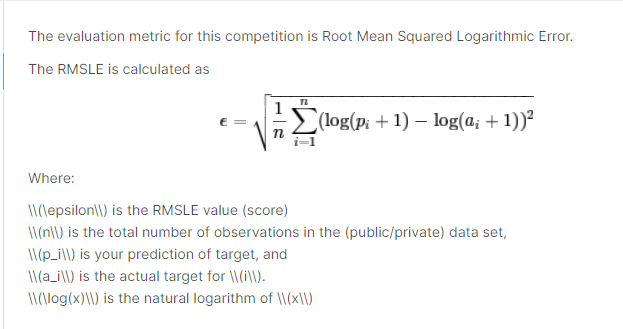

In [43]:
# métrica dita pela kaggle
from sklearn.metrics import mean_squared_log_error

In [44]:
y_train_pred = reg.predict(X_train_sel)
y_pred = reg.predict(X_test_sel)

In [45]:
y_train = y_train[y_train_pred > 0]
y_train_pred = y_train_pred[y_train_pred > 0]
y_test = y_test[y_pred > 0]
y_pred = y_pred[y_pred > 0]

In [46]:
print(mean_squared_log_error(y_train, y_train_pred))
print(mean_squared_log_error(y_test, y_pred))

3.911277869992661
3.7452270716462395


Pode-se ver que o valor de RMSLE é muito melhor que o MAE, mas calma, vamos entender mellhor o porquê disso:
1. O RMSLE não é atingido pelos outliers como os outras métricas, ou seja, como os valoresestão muitos dispersos, por serem muito altos, podem afetam a metrica passada.
2. O RMSLE não é medido em escala (no caso monetário aqui), ele mede erro relativo e a escala do erro não é significativa
3. Ele penaliza muitíssimo valores negativos, pois neste caso não queremos saber de valores negativos, queremos saber os valores das transações, porém o modelo de previsão pode prever valores negativos., portanto utilizamos >0.

## Melhorar o resultado

In [47]:
# separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [48]:
# selecionando as 45 melhores colunas
sel_kbest = SelectKBest(f_regression, k=45).fit(X_train, y_train)
X_train_sel = sel_kbest.transform(X_train)
X_test_sel = sel_kbest.transform(X_test)

In [49]:
# treinando o modelo de Random Forest
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=6, random_state=0)
regr.fit(X_train_sel, y_train)

RandomForestRegressor(max_depth=6, random_state=0)

In [50]:
# fazendo a predição e calculando as métricas
y_train_pred = regr.predict(X_train_sel)
y_pred = regr.predict(X_test_sel)


print(mean_squared_log_error(y_train, y_train_pred))
print(mean_squared_log_error(y_test, y_pred))

3.832475327822927
3.719739927585444


In [51]:
# melhorando hiperparâmetros com Gridsearch
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[2, 6, 10, 20], 'n_estimators':[20, 50, 100, 200]}
regr = RandomForestRegressor(random_state=0, n_jobs=-1)

clf = GridSearchCV(regr, parameters)
clf.fit(X_train_sel, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [2, 6, 10, 20],
                         'n_estimators': [20, 50, 100, 200]})

In [52]:
# fazendo a predição com os melhores parâmetros
y_train_pred = clf.predict(X_train_sel)
y_pred = clf.predict(X_test_sel)


print(mean_squared_log_error(y_train, y_train_pred))
print(mean_squared_log_error(y_test, y_pred))

2.6419218238697284
3.229333335021272


Podemos concluir que esta foi a melhor predição, melhorando os hiperparâmetros com a métrica de RMSLE. 

In [54]:
# obtendo os melhores valores de hiperparâmetros
clf.best_estimator_

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1, random_state=0)